In [2]:
cd ../..

/userdata/jgauthier/projects/ideal-word-representations


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
from pathlib import Path
import pickle

In [5]:
feature_selection_paths = list(Path("outputs/synthetic_encoders").glob("**/forward_selection.pkl"))
feature_selection_paths

[PosixPath('outputs/synthetic_encoders/timit/w2v2_3/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_3/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_9/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_9/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_6/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_6/basic50/forward_selection.pkl')]

In [6]:
feature_selection_results = {}
for path in feature_selection_paths:
    with open(path, "rb") as f:
        key = (path.parent.name, path.parents[1].name)
        result = pickle.load(f)
        feature_selection_results[key] = {"spec_trajectory": result["spec_trajectory"], "score_trajectory": result["score_trajectory"]}

In [7]:
score_df = pd.DataFrame([feature_selection_results[key]["score_trajectory"] for key in feature_selection_results],
                        index=pd.MultiIndex.from_tuples(feature_selection_results.keys(), names=["encoder", "base_model"])) \
                            .reset_index().melt(id_vars=["encoder", "base_model"], var_name="step", value_name="score")
score_df

,encoder,base_model,step,score
0,basic10,w2v2_3,0,-inf
1,basic50,w2v2_3,0,-inf
2,basic50,w2v2_9,0,-inf
3,basic10,w2v2_9,0,-inf
4,basic10,w2v2_6,0,-inf
5,basic50,w2v2_6,0,-inf
6,basic10,w2v2_3,1,0.104165
7,basic50,w2v2_3,1,0.042489
8,basic50,w2v2_9,1,0.046446
9,basic10,w2v2_9,1,0.111842


In [8]:
selection_df = pd.DataFrame([[traj[-1] if len(traj) > 0 else None
                            for traj in feature_selection_results[key]["spec_trajectory"]]
                            for key in feature_selection_results],
                            index=pd.MultiIndex.from_tuples(feature_selection_results.keys(), names=["encoder", "base_model"])).reset_index() \
    .melt(id_vars=["encoder", "base_model"], var_name="step", value_name="selected_embedding") \
    .dropna()
selection_df

,encoder,base_model,step,selected_embedding
6,basic10,w2v2_3,1,phoneme8
7,basic50,w2v2_3,1,phoneme8
8,basic50,w2v2_9,1,phoneme8
9,basic10,w2v2_9,1,phoneme8
10,basic10,w2v2_6,1,phoneme8
11,basic50,w2v2_6,1,phoneme8
12,basic10,w2v2_3,2,syllable
13,basic50,w2v2_3,2,syllable
14,basic50,w2v2_9,2,syllable
15,basic10,w2v2_9,2,syllable


In [9]:
merged_df = score_df.merge(selection_df, on=["encoder", "base_model", "step"]).set_index(["encoder", "base_model", "step"]).sort_index()
merged_df["improvement"] = merged_df.score.diff()
merged_df.loc[merged_df.index.get_level_values("step") == 1, "improvement"] = merged_df.loc[merged_df.index.get_level_values("step") == 1, "score"]
merged_df = merged_df.reset_index()

<Axes: xlabel='step', ylabel='score'>

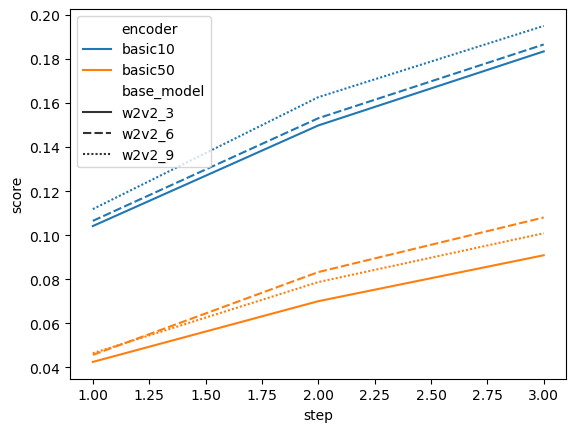

In [10]:
merged_df.pipe((sns.lineplot, "data"), x="step", y="score", hue="encoder", style="base_model")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jgauthier/

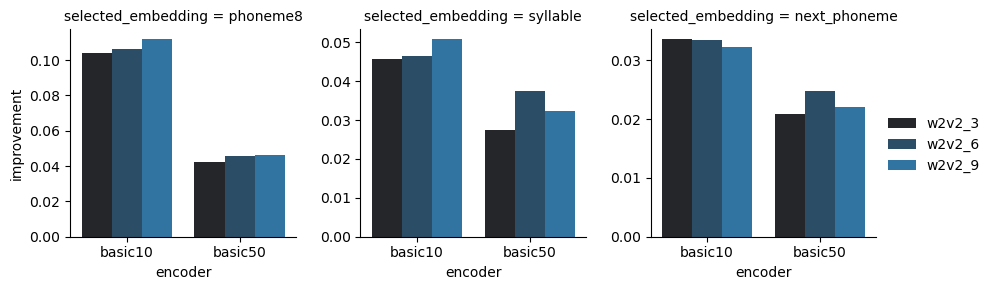

In [13]:
g = sns.FacetGrid(merged_df, col="selected_embedding", sharey=False)
g.map(sns.barplot, "encoder", "improvement", "base_model")
g.add_legend()